# Prompt engineering on worst econ questions: answer verification, temperature, red/blue, context

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
from ollama_models import ollama_models
models = ollama_models()

In [3]:
models

['mistral-small3.2:24b-instruct-2506-q4_K_M']

In [4]:
model = models[0]

In [5]:
from community_alignment import community_alignment

Loaded existing index from forecast_index.faiss
Index contains 5839 vectors at initialization


100%|███████████████████████████████████████████████| 113/113 [00:00<00:00, 27359.95it/s]

saved community_deepseek-r1:1.5b-qwen-distill-q4_K_M.json


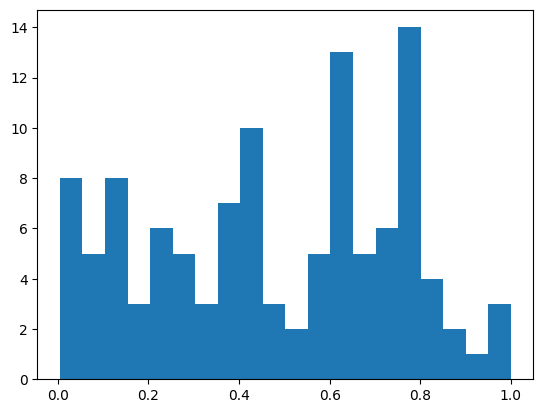

In [6]:
df = community_alignment('deepseek-r1:1.5b-qwen-distill-q4_K_M')

In [11]:
from load_saved_questions import load_saved_questions
from call_local_llm import call_local_llm

In [10]:
df.question_type.unique()

array(['binary', 'numeric'], dtype=object)

In [8]:
df[['id', 'question_type', 'error']].sort_values(by='error', ascending=False)

,id,question_type,error
110,4083,numeric,1.000000
4,3095,numeric,1.000000
53,4830,numeric,1.000000
83,17763,binary,0.940000
12,12348,binary,0.890000
...,...,...,...
70,15146,binary,0.030000
17,3665,binary,0.030000
21,15964,binary,0.010000
90,8583,binary,0.010000


In [17]:
question = load_saved_questions([3095])[0]

In [18]:
    from community_forecast import community_forecast
    import pandas as pd
    from flatten_dict import flatten_dict
    from datetime import datetime
    from gather_research_and_set_prompt import gather_research_and_set_prompt
    from generate_forecasts_and_update_rag import generate_forecasts_and_update_rag
    from tqdm import tqdm
    import time

In [19]:
    print('START model', model, 'id', id)
    start_time = time.time()
    questions = [question]
    id = question.id_of_question
    id_to_forecast = {question.id_of_question: community_forecast(question) for question in questions}
    df = pd.DataFrame([flatten_dict(q.api_json, sep='_') for q in questions])
    df['id_of_post'] = [q.id_of_post for q in questions]
    df['id_of_question'] = [q.id_of_question for q in questions]
    df['question_options'] = df['question_options'].apply(repr)
    df['today'] = datetime.now().strftime("%Y-%m-%d")
    df['crowd'] = df.apply(lambda row: id_to_forecast[row.id_of_question], axis=1)

START model mistral-small3.2:24b-instruct-2506-q4_K_M id <built-in function id>


In [20]:
    df1 = df[['id_of_question', 'id_of_post', 'today', 'open_time', 'scheduled_resolve_time', 'title',
        'question_resolution_criteria', 'question_fine_print', 'question_type', 
         'question_description',
        'question_options', 'question_group_variable', 'question_question_weight',
        'question_unit', 'question_open_upper_bound', 'question_open_lower_bound',
        'question_scaling_range_max', 'question_scaling_range_min', 'question_scaling_zero_point','crowd']].copy()

In [21]:
    df2, rag = gather_research_and_set_prompt(df1, True, model)

Loaded existing index from forecast_index.faiss
Index contains 5839 vectors at initialization


In [22]:
df3 = df2[['id_of_question', 'title',
        'question_resolution_criteria', 'question_fine_print', 'question_type', 
         'question_description',
        'question_options', 'question_group_variable', 'question_question_weight',
        'question_unit', 'question_open_upper_bound', 'question_open_lower_bound',
        'question_scaling_range_max', 'question_scaling_range_min', 'question_scaling_zero_point','crowd',
          'research', 'asknews', 'learning']].copy()

In [23]:
row = df3.iloc[0]

In [24]:
row

id_of_question                                                               3095
title                           What will the US market for plant-based meat b...
question_resolution_criteria    Data from [SPINS](https://www.spins.com/) summ...
question_fine_print                                                              
question_type                                                             numeric
question_description                                                             
question_options                                                             None
question_group_variable                                                          
question_question_weight                                                      1.0
question_unit                                                               M USD
question_open_upper_bound                                                    True
question_open_lower_bound                                                    True
question_scaling

In [25]:
for item, value in row.items():
    print(item.upper())
    print()
    print(value)
    print('===============================')
    print()

ID_OF_QUESTION

3095

TITLE

What will the US market for plant-based meat be worth in the year ending in April 2028?

QUESTION_RESOLUTION_CRITERIA

Data from [SPINS](https://www.spins.com/) summarised by the Plant Based Foods Association and The Good Food Institute shows U.S. retail sales of plant-based alternative foods have grown 11 percent in the past year, and 31% over the past two years ([Good Food Institute, 2019](https://www.gfi.org/marketresearch#section-intro)). By comparison, total U.S. retail food dollar sales grew just 2% over the past year and 4% over the past two years.

This brings the total plant-based alternatives market value to a total value of $4.5 billion in 2019. At [an estimated $801M](https://plantbasedfoods.org/2019-data-plant-based-market/) the plant-based meat market is the second highest grossing plant-based alternatives product, after plant-based milk.

Most dollar-sales of plant-based meat tend to come from frozen products (73% in 2019). However, this seem

In [26]:
row.question_resolution_criteria

"Data from [SPINS](https://www.spins.com/) summarised by the Plant Based Foods Association and The Good Food Institute shows U.S. retail sales of plant-based alternative foods have grown 11 percent in the past year, and 31% over the past two years ([Good Food Institute, 2019](https://www.gfi.org/marketresearch#section-intro)). By comparison, total U.S. retail food dollar sales grew just 2% over the past year and 4% over the past two years.\n\nThis brings the total plant-based alternatives market value to a total value of $4.5 billion in 2019. At [an estimated $801M](https://plantbasedfoods.org/2019-data-plant-based-market/) the plant-based meat market is the second highest grossing plant-based alternatives product, after plant-based milk.\n\nMost dollar-sales of plant-based meat tend to come from frozen products (73% in 2019). However, this seems to changing quickly: product innovation and merchandising strategies have grown dollar sales of refrigerated plant-based meat by 85% ([Good F

In [27]:
prompt = f"""Here is some information about a question:

TITLE
=====

{row.title}

RESOLUTION CRITERIA
===================

{row.question_resolution_criteria}

SCALE
=====

From {row.question_scaling_range_min} to {row.question_scaling_range_max}

Using the information, answer the following questions:

a.  What is the minimum value for the answer?
b.  What is the maximum value for the answer?
c.  Is there a formula for the answer given in the above text?
d.  If there is a formula, what needs to go into the formula and how do you estimate it?  Write a python function for the formula, commenting its inputs and outputs for clarity
"""

In [ ]:
print(prompt)

In [29]:
terms = call_local_llm(prompt, model)

START model mistral-small3.2:24b-instruct-2506-q4_K_M
model mistral-small3.2:24b-instruct-2506-q4_K_M minutes 2.803510057926178


In [31]:
print(terms)

a. The minimum value for the answer is **800.0** (as per the SCALE provided in the text).

b. The maximum value for the answer is **100,000.0** (as per the SCALE provided in the text).

c. There is no explicit formula provided in the text for calculating the future market value of plant-based meat in the U.S. in 2028. The resolution criteria rely on SPINS data, which is not directly provided or described in a formulaic way.

d. Since no formula is explicitly given, we cannot write a Python function for it. However, if we were to estimate the future market value based on historical growth rates (as mentioned in the text), we could use a simple compound annual growth rate (CAGR) approach. Here’s a hypothetical Python function based on that assumption:

```python
def estimate_future_market_value(initial_value, growth_rate, years):
    """
    Estimates the future market value using compound annual growth rate (CAGR).

    Parameters:
    - initial_value (float): The initial market value (

In [33]:
prompt2 = f"""
You are the intelligence community's best geopolitical, economic and overall news trivia forecaster.  
You are given the following information to make a prediction:

```title
{row.title}
```

```news
{row.asknews}

```research
{row.research}
```

Using the title, news and research, make a forecast according to the formulas you derived in the previous prompt response.
If the Python function has multiple variables, assess each variable individually and then use the function to compute the measure.

The last thing you write is your final answer as this sequence of percentile levels in percent and values as floating point numbers without currency symbols, commas or spelled out numbers like "trillion", just the raw complete number:
"
Percentile 10: XX
Percentile 20: XX
Percentile 40: XX
Percentile 60: XX
Percentile 80: XX
Percentile 90: XX
"
Each line of the final answer MUST START with the word "Percentile".  For example if you have "10: 201" instead of "Percentile 10: 201", that is wrong.

PLEASE REMEMBER THAT THE ANSWER MUST BE IN THE TERMS REQUESTED BY THE PROBLEM.  
A QUICK CORRECTNESS CHECK IS THAT YOUR ANSWER MUST LIE BETWEEN THE MINIMUM AND MAXIMUM VALUES SPECIFIED.  
THE REQUESTED TERMS ARE AS FOLLOWS:

```terms
{terms}
```
"""

In [34]:
print(prompt2)


You are the intelligence community's best geopolitical, economic and overall news trivia forecaster.  
You are given the following information to make a prediction:

```title
What will the US market for plant-based meat be worth in the year ending in April 2028?
```

```news
Here are the relevant news articles:

**United States Plant Based Meat Market Growth Trends Report 2025-2033: $15 Billion Industry Faces Competitions from Lab-Grown and Insect Proteins as Market Diversifies - ResearchAndMarkets.com**
The United States plant-based meat market is expected to reach $15.12 billion by 2033, growing at a CAGR of 19.91% from 2025 to 2033. The market is driven by factors such as increased awareness of health and wellness implications, environmental sustainability, and ethical concerns. Companies like Beyond Meat and Impossible Foods are leading the way with products that mimic the taste and texture of conventional meat. However, the industry still faces challenges such as production scali

In [35]:
answer_mistral = call_local_llm(prompt2, model_mistral)

answer_mistral2 = call_local_llm(prompt2, model_mistral)

answer_mistral3 = call_local_llm(prompt2, model_mistral)

START model mistral-small3.2:24b-instruct-2506-q4_K_M
model mistral-small3.2:24b-instruct-2506-q4_K_M minutes 4.783025630315145
START model mistral-small3.2:24b-instruct-2506-q4_K_M
model mistral-small3.2:24b-instruct-2506-q4_K_M minutes 4.896182092030843
START model mistral-small3.2:24b-instruct-2506-q4_K_M
model mistral-small3.2:24b-instruct-2506-q4_K_M minutes 5.349415183067322


In [36]:
from extract_forecast import extract_percentile_numbers

In [37]:
forecasts = [extract_percentile_numbers(x) for x in [answer_mistral, answer_mistral2, answer_mistral3]]

In [38]:
forecasts

[{10: 1050.0, 20: 1150.0, 40: 1300.0, 60: 1550.0, 80: 1800.0, 90: 2220.0},
 {10: 1054.1, 20: 1165.3, 40: 1270.4, 60: 1376.6, 80: 1778.5, 90: 2080.4},
 {10: 1120.0, 20: 1300.0, 40: 1570.0, 60: 2010.0, 80: 2220.0, 90: 2800.0}]

In [39]:
from median_dictionaries import median_dictionaries

In [40]:
forecast = median_dictionaries(forecasts)

In [41]:
forecast

{10: 1054.1, 20: 1165.3, 40: 1300.0, 60: 1550.0, 80: 1800.0, 90: 2220.0}

In [42]:
prompt = f"""
Summarize the gist pf the rationale or thinking of the following answers from 3 different forecasters to a single problem. 

```forecast 1
{answer_mistral}
```

```forecast 2
{answer_mistral2}
```

```forecast 3
{answer_mistral3}
```

DO NOT REFER TO THE 3 FORECASTERS.  PRESENT THIS AS YOUR OWN THINKING, YOUR OWN RATIONALE.  Use as your final the median forecast which is

```median forecast
{forecast}
```
"""

In [43]:
rationale = call_local_llm(prompt, model_mistral)

START model mistral-small3.2:24b-instruct-2506-q4_K_M
model mistral-small3.2:24b-instruct-2506-q4_K_M minutes 3.5563150962193806


In [44]:
print(rationale)

To forecast the future market value of plant-based meat in the U.S. in 2028, I will use the compound annual growth rate (CAGR) approach based on historical data. Here's the step-by-step reasoning:

### Key Data Points:
1. **Initial Value (2019):** $801 million (from SPINS data).
2. **Historical Growth Rate (2017–2019):** 11–12% CAGR.
3. **Projected Growth Rate (2025–2030):** 2.81% CAGR (from Statista).
4. **Years to Project:** 2019 to 2028 = 9 years.

### Assumptions:
- We'll use a blended growth rate to account for decelerating growth. A reasonable midpoint is 7% CAGR for the first 5 years (2019–2024) and 3% CAGR for the next 4 years (2024–2028).
- Inflation adjustment is not applied here, as the problem does not specify it.

### Calculation:
1. **First 5 Years (2019–2024):**
   - Future Value = $801M * (1 + 0.07)^5 ≈ $1,120M.
2. **Next 4 Years (2024–2028):**
   - Future Value = $1,120M * (1 + 0.03)^4 ≈ $1,260M.

### Probabilistic Forecast:
We'll model the uncertainty by varying the g

In [45]:
row.forecast = rationale

In [46]:
row.prediction = forecast

In [47]:
row.crowd

{10: 979.8762472281021,
 20: 2004.4326826429779,
 40: 3296.5149388407367,
 60: 5427.301502268182,
 80: 11280.270569827479,
 90: 23522.984940687176}

In [48]:
from error import error

In [49]:
error(row)

0.6738770473449628